# Item Categorization

### Methodology = Multilingual Embeddings -> HDBSCAN Clustering -> LLM

#### 1.  Data Processing

In [1]:
# Load and clean the purchase order data
import pandas as pd

# Load the purchase order data from an Excel file
df = pd.read_excel('purchase-order-items.xlsx')
print(f"\nOriginal shape: {df.shape}")

# Drop a Project ID column since it doesn't contain any values
df = df.drop('Project ID', axis=1)

# Remove rows with any NaN values
df_cleaned = df.dropna()

# convert from float to integers (after NaN values are removed)
df_cleaned['Product ID'] = df_cleaned['Product ID'].astype('int64')
df_cleaned['Tax ID'] = df_cleaned['Tax ID'].astype('int64')

# Display the cleaned data
print(df_cleaned.head(5))
print(f"Cleaned shape: {df_cleaned.shape}")


Original shape: (3150, 11)
                 Item ID                           Item Name  Quantity  \
233  3263831000000763127            HEB 200X200X15X9MMX12MTR      75.0   
234  3263831000000763149         HEB 280X280X10.5X18MMX12MTR      35.0   
235  3263831000000763145          IPE 300X150X7.1X10.7X12MTR      15.0   
236  3263831000000763143         HEB 260X260X10X17.5MMX12MTR      17.0   
237  3263831000000763151  Corrugated Sheet 1x6 mtr x 0.50 mm     139.0   

     Total Bcy  Sub Total Bcy    Purchase Order ID           Product ID  \
233   215250.0       215250.0  3263831000000763125  3263831000000755200   
234   172900.0       172900.0  3263831000000763125  3263831000000755200   
235    28860.0        28860.0  3263831000000763125  3263831000000756736   
236    75820.0        75820.0  3263831000000763125  3263831000000759296   
237    20850.0        20850.0  3263831000000763125  3263831000000759808   

    Currency Code           Account ID               Tax ID  
233           

C:\Users\Abdallah\AppData\Local\Temp\ipykernel_27592\105658993.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Product ID'] = df_cleaned['Product ID'].astype('int64')
C:\Users\Abdallah\AppData\Local\Temp\ipykernel_27592\105658993.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Tax ID'] = df_cleaned['Tax ID'].astype('int64')


#### 2. Multilingual Embeddings (LaBSE)

In [2]:
from sentence_transformers import SentenceTransformer

# Use a multilingual model
model = SentenceTransformer('sentence-transformers/LaBSE')

item_names = df_cleaned['Item Name'].tolist()
embeddings = model.encode(item_names, show_progress_bar=True)

#size of the embeddings
print("Embeddings shape:", embeddings.shape)

c:\Users\Abdallah\miniconda3\envs\ajil\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Batches: 100%|██████████| 89/89 [00:22<00:00,  3.88it/s]

Embeddings shape: (2845, 768)


#### 3. Clustering (HDBSCAN)

In [3]:
import hdbscan
import umap

# Reduce dimensionality with UMAP
umap_reducer = umap.UMAP(n_components= 15, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings)

print("UMAP embeddings shape:", embeddings_umap.shape)

clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10)
df_cleaned['Category'] = clusterer.fit_predict(embeddings_umap)


c:\Users\Abdallah\miniconda3\envs\ajil\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embeddings shape: (2845, 15)


c:\Users\Abdallah\miniconda3\envs\ajil\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Abdallah\miniconda3\envs\ajil\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Abdallah\AppData\Local\Temp\ipykernel_27592\4194754216.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Category'] = clusterer.fit_predict(embeddings_umap)


#### 4. Visualization

##### 2D

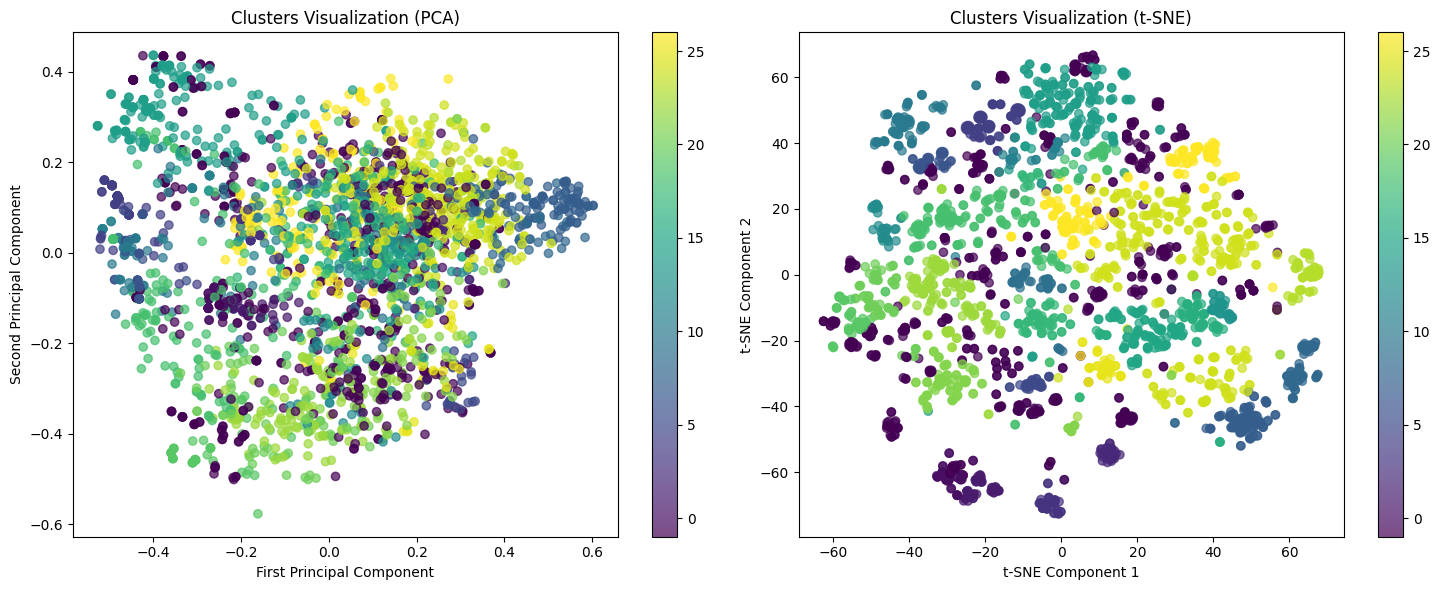


Cluster Statistics:
Category
-1     601
 0      41
 1      40
 2      33
 3      41
 4      78
 5      31
 6      41
 7      93
 8      67
 9      42
 10     81
 11     32
 12     32
 13     34
 14    206
 15    103
 16     69
 17     69
 18    188
 19     51
 20     66
 21     89
 22    143
 23     59
 24    313
 25     40
 26    162
Name: count, dtype: int64

Number of clusters found: 27
Number of noise points (outliers): 601


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Reduce dimensionality for visualization (2D)
# Option 1: Using PCA
pca = PCA(n_components=2, random_state=42)
embeddings_2d_pca = pca.fit_transform(embeddings)

# Option 2: Using t-SNE (better for visualization but slower)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot PCA results
scatter1 = axes[0].scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1], 
                          c=df_cleaned['Category'], cmap='viridis', alpha=0.7)
axes[0].set_title('Clusters Visualization (PCA)')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0])

# Plot t-SNE results
scatter2 = axes[1].scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], 
                          c=df_cleaned['Category'], cmap='viridis', alpha=0.7)
axes[1].set_title('Clusters Visualization (t-SNE)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

# Print cluster statistics
print("\nCluster Statistics:")
cluster_counts = df_cleaned['Category'].value_counts().sort_index()
print(cluster_counts)
print(f"\nNumber of clusters found: {len(cluster_counts[cluster_counts.index >= 0])}")
print(f"Number of noise points (outliers): {(df_cleaned['Category'] == -1).sum()}")

#### 3D

In [5]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import pandas as pd
import plotly.offline as pyo


# Reduce dimensionality to 3D using PCA
pca_3d = PCA(n_components=3, random_state=42)
embeddings_3d = pca_3d.fit_transform(embeddings)

# Create a DataFrame for Plotly
plot_df = pd.DataFrame({
    'PC1': embeddings_3d[:, 0],
    'PC2': embeddings_3d[:, 1], 
    'PC3': embeddings_3d[:, 2],
    'Category': df_cleaned['Category'].astype(str),
    'Item_Name': df_cleaned['Item Name'],
    'Product_ID': df_cleaned['Product ID']
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    plot_df, 
    x='PC1', y='PC2', z='PC3',
    color='Category',
    hover_data=['Item_Name', 'Product_ID'],
    title='Interactive 3D Clusters Visualization (PCA)',
    labels={'PC1': 'Principal Component 1',
            'PC2': 'Principal Component 2', 
            'PC3': 'Principal Component 3'}
)

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    width=900,
    height=600
)

# Display
fig.show()

In [6]:
# Show 10 random samples from each category
sampled = df_cleaned.groupby('Category').apply(lambda x: x.sample(n=min(5, len(x)), random_state=42)).reset_index(drop=True)
display(sampled[['Category', 'Item Name']])

C:\Users\Abdallah\AppData\Local\Temp\ipykernel_27592\515006303.py:2: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Category,Item Name
0,-1,WEICCO RUBBER LINED SPLIT CLAMP MODEL: WSC 158...
1,-1,"WIRE MESH 4X1.5M 8"" 8MM"
2,-1,PETROMIN HYDRAULIC OIL AW 68
3,-1,ورد صاج صلب دن 6916 مخلفن على الحار
4,-1,"CABLE TRAY STANDARD ANGLE CONNECTOR,FOR 100 MM..."
...,...,...
135,26,ربل 4 ملم مبروم اسود
136,26,ماسورة 110 ملم رمادي 4 CLASS نيبرو ربر
137,26,DLC Interlock direct door E2.2ΓÇªE6.2
138,26,ماسورة ٢٥م حراري تحويل


#### 5. Cluster Labeling with LLM (DeepSeek)

In [ ]:
# Sample 10 items from each cluster and send to DeepSeek for categorization
from openai import OpenAI
import random
import os
from dotenv import load_dotenv

# Load API key from .env file
load_dotenv()
api_key = os.getenv("DEEPSEE_API_KEY")
# Initialize DeepSeek client
client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")

# Get unique clusters (excluding noise cluster -1 if needed)
unique_clusters = sorted(df_cleaned['Category'].unique())
unique_clusters = [c for c in unique_clusters if c >= 0]  # Remove noise cluster if present

# Dictionary to store categorization results
cluster_categories = {}

# Function to get category from DeepSeek
def get_category_from_deepseek(items):
    items_text = "\n".join([f"{i+1}. {item}" for i, item in enumerate(items)])
    
    prompt = f"""Your task is to identify the single, most general common category that a given list of items belongs to.  Respond only with the name of that category in English. Do not add any other text, explanations, or commentary.
    
    Items:\n{items_text}
    """
    
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "You are an expert categorizer."},
            {"role": "user", "content": prompt},
        ],
        stream=False
    )
    
    return response.choices[0].message.content

# Process each cluster
for cluster in unique_clusters:
    # Get all items in this cluster
    cluster_items = df_cleaned[df_cleaned['Category'] == cluster]['Item Name'].tolist()
    
    # Sample 10 items (or all if less than 10)
    sample_size = min(10, len(cluster_items))
    sample_items = random.sample(cluster_items, sample_size)
    
    print(f"\nProcessing Cluster {cluster} with {len(cluster_items)} items")
    print(f"Sample items: {sample_items[:3]}...")
    
    # Get category from DeepSeek
    try:
        category_info = get_category_from_deepseek(sample_items)
        cluster_categories[cluster] = category_info
        print(f"DeepSeek categorization: {category_info}")
    except Exception as e:
        print(f"Error processing cluster {cluster}: {e}")

# Save results to dataframe
df_cleaned['DeepSeek_Category'] = df_cleaned['Category'].map(lambda x: cluster_categories.get(x, "Uncategorized"))



Processing Cluster 0 with 41 items
Sample items: ['09.0 mm Plain Wire Rod in Coil -SABIC', '11.0 mm Plain Wire Rod in Coil - SABIC', '25.0 mm Black Deformed Straight Bar G60 - 12 M-Sabic']...
DeepSeek categorization: Steel bars

Processing Cluster 1 with 40 items
Sample items: ['25.0 mm Black Deformed Straight Bar G60 - 12M - Ittifaq', '16.0 mm black deformed straight bar G60-12M - Ittefaq', '14.0 mm Black Deformed Straight Bar G60 - 12 M WATANI']...
DeepSeek categorization: Steel bars

Processing Cluster 2 with 33 items
Sample items: ['CRANKSHAFT SEAL (Configuration:Seal Size:NONE Color:MFMX924852 Style:MITSUBISHI', 'ALTERNATOR ASSEMBLY-MXg1 5335 (Configuration:ALTERNATOR ASSY. Size:NONE Color:MX915335 Style:FUSO', 'BRAKE DRUM (Configuration:Rear Size:NONE Color:MFMX925023 Style:FUSO REL 22Y']...
DeepSeek categorization: AUTOMOTIVE PARTS

Processing Cluster 3 with 41 items
Sample items: ['08.0 mm Deformed straight Bar - CR - 6M (Unit: Ton)', '09.5 mm Deformed Straight Bar -CR - 12 M'

C:\Users\Abdallah\AppData\Local\Temp\ipykernel_27592\4257816931.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Abdallah\AppData\Local\Temp\ipykernel_27592\4257816931.py:62: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




Categorization complete! Results saved to 'categorized_purchase_orders.xlsx'


In [11]:
# Simple print of all unique categories
print("\nAll DeepSeek Categories:")
print(len(df_cleaned['DeepSeek_Category'].unique()))
print(df_cleaned['DeepSeek_Category'].unique())


All DeepSeek Categories:
22
['Metal products' 'Steel profiles' 'Uncategorized'
 'Steel pipes and construction materials' 'Metal sheets'
 'Hardware components' 'Cable tray system components'
 'Electrical components and equipment' 'Electrical components'
 'Steel reinforcement bars' 'Steel bars' 'Construction materials'
 'Sheet metal' 'Electrical cables' 'Steel rebar' 'electrical components'
 'Plumbing fittings' 'Pipe fittings' 'Circuit breakers'
 'Bathroom fixtures and accessories' 'Building materials'
 'AUTOMOTIVE PARTS']


#### 6. Categorize items based on the rules

In [ ]:
''' using rule-based approach to refine DeepSeek generated categories '''


# Create a function that applies rules to categorize items
def get_general_category(category):
    # Convert to lowercase for case-insensitive matching
    cat_lower = category.lower()
    
    # Metal products rule
    if any(keyword in cat_lower for keyword in ['metal', 'sheet']):
        return 'Metal Products'
    
    # Steel products rule
    elif any(keyword in cat_lower for keyword in ['steel', 'rebar', 'profiles', 'pipes']):
        return 'Steel Products'
    
    # Electrical products rule
    elif any(keyword in cat_lower for keyword in ['electrical', 'circuit', 'cable', 'breaker']):
        return 'Electrical Products'
    
    # Construction materials rule
    elif any(keyword in cat_lower for keyword in ['construction', 'building']):
        return 'Construction Materials'
    
    # Plumbing products rule
    elif any(keyword in cat_lower for keyword in ['plumbing', 'pipe fitting', 'bathroom', 'fixtures']):
        return 'Plumbing Products'
    
    # Hardware products rule
    elif 'hardware' in cat_lower:
        return 'Hardware Products'
    
    # Automotive products rule
    elif 'automotive' in cat_lower:
        return 'Automotive Products'
    
    # Default case - keep original category
    else:
        return category

# Apply the rule-based function to create the new column
df_cleaned['General_Category'] = df_cleaned['DeepSeek_Category'].apply(get_general_category)

# Print the unique general categories
print(df_cleaned['General_Category'].unique())

# Save the updated dataframe to Excel
df_cleaned.to_excel('categorized_purchase_orders.xlsx', index=False)

['Metal Products' 'Steel Products' 'Uncategorized' 'Hardware Products'
 'Electrical Products' 'Construction Materials' 'Plumbing Products'
 'Automotive Products']
